# Stanford Microplastics Data

Research Paper with Data: https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.15533


### Import Required Libraries

In [1]:
import os
import json
import requests
from pprint import pprint
from datetime import date, timedelta, datetime
from io import BytesIO
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import xgboost as xgb

import earthaccess

### Load in downloaded data

In [2]:
# load the microplastic count per fish data
data_path = "/Users/ds/Downloads/GCB-27-2188-s001.xlsx"
# df1 = pd.read_excel(data_path, header=1, usecols='C:H', names=['station','latin','length_cm','weight_g', 'shape','mp_length_um'])
df = pd.read_excel(data_path, header=0)
print(df.describe(),'\n')
print(df.info())

       Trophic level  Num. w plastic  Total num. sampled  FO of plastic  \
count     781.000000      768.000000          785.000000     768.000000   
mean        3.618822       10.444010          218.820382       0.300826   
std         0.600634       31.629776         1305.028916       0.352190   
min         2.000000        0.000000            1.000000       0.000000   
25%         3.300000        0.000000            4.000000       0.000000   
50%         3.600000        2.000000           17.000000       0.166667   
75%         4.100000        9.000000           56.000000       0.500000   
max         4.900000      506.000000        25914.000000       1.000000   

       Mean num particles per indv  Average depth found  Vulnerability score  \
count                   624.000000           707.000000           779.000000   
mean                      3.139573           210.512730            42.593068   
std                      50.820799           304.405418            17.954241   
min 

In [3]:
cols_of_interest = ['Scientific name',
                     'Common name',
#                      'Order',
#                      'Family',
                     'Trophic level',
                     'Num. w plastic',
                     'Total num. sampled',
                     'FO of plastic',
                     'Mean num particles per indv',
                     'Habitat',
                     'Average depth found',
                     'Primary foraging behavior',
                     'Commercial status',
                     'Aquaculture status',
                     'Recreational status',
#                      'IUCN status',
#                      'Vulnerability score',
                     'Oceanographic province',
#                      'Year of collection',
#                      'Publication year',
#                      'Reference',
                     'Quantified microplastic',
#                      'Method type',
                     'Marine/estuarine',
#                      'Equipment used',
#                      'Capture purpose',
                     'Polymer confirmation',
#                      'Blanks used',
#                      'Clean lab procedures used'
                   ]

# redefine dataframe with just columns of interest
df_coi = df[cols_of_interest]

# take a quick look at the new df
print(df_coi.describe())
print()
print(df_coi.info())

       Trophic level  Num. w plastic  Total num. sampled  FO of plastic  \
count     781.000000      768.000000          785.000000     768.000000   
mean        3.618822       10.444010          218.820382       0.300826   
std         0.600634       31.629776         1305.028916       0.352190   
min         2.000000        0.000000            1.000000       0.000000   
25%         3.300000        0.000000            4.000000       0.000000   
50%         3.600000        2.000000           17.000000       0.166667   
75%         4.100000        9.000000           56.000000       0.500000   
max         4.900000      506.000000        25914.000000       1.000000   

       Mean num particles per indv  Average depth found  
count                   624.000000           707.000000  
mean                      3.139573           210.512730  
std                      50.820799           304.405418  
min                       0.000000             1.000000  
25%                       0.000000

### Check Column Datatypes

In [4]:
### look at the data in the object columns to determine which need ordinal encoding

# get columns that are of object type
obj_cols = [df_coi[col].dtype == np.dtype('O') for col in df_coi.columns]
num_cols = [not val for val in obj_cols]

# get list of object columns to encode
cols_to_encode = df_coi.columns[obj_cols]
# print('Columns of dtype(\'O\'):\n',str(list(cols_to_encode)).replace(', ',',\n  '),'\n')

# get unique values and info for each column to encode
unique_vals = {col : len(df_coi[col].unique()) for col in cols_to_encode}
print('Unique Value counts by column:\n',str(unique_vals).replace(', ',',\n  '))

Unique Value counts by column:
 {'Scientific name': 577,
  'Common name': 531,
  'Habitat': 10,
  'Primary foraging behavior': 10,
  'Commercial status': 7,
  'Aquaculture status': 5,
  'Recreational status': 3,
  'Oceanographic province': 30,
  'Quantified microplastic': 2,
  'Marine/estuarine': 2,
  'Polymer confirmation': 6}


### Numeric Column Correlation Matrix

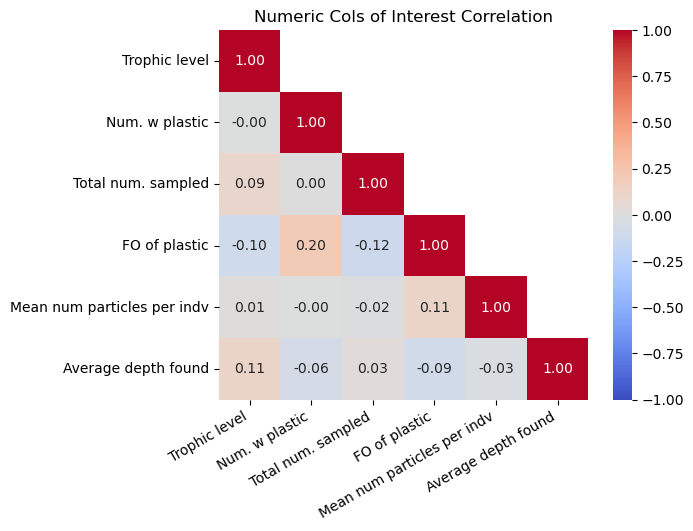

In [5]:
# asign variable for df with just the object columns
df_coi_obj = df_coi[df_coi.columns[obj_cols]]

# asign variable for df with just the numeric columns
df_coi_num = df_coi[df_coi.columns[num_cols]]

# get the correlation matrix for numeric values
corr_mat = df_coi_num.corr()
disp_mask = np.triu(np.ones_like(df_coi_num.corr(), dtype=bool),k=1)

# quick heatmap of correlation matrix for numeric columns of interest
sns.heatmap(df_coi_num.corr(), 
            mask=disp_mask, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            square=True, 
            fmt=".2f")
plt.xticks(rotation=30, ha='right')
plt.title('Numeric Cols of Interest Correlation')
plt.show()

### Quick EDA Visualizations

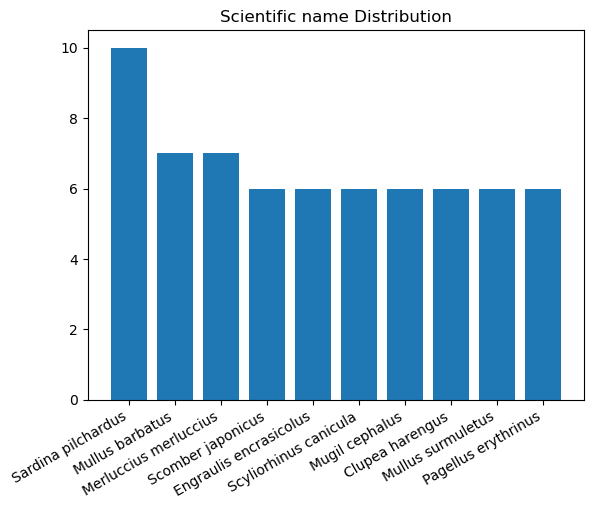

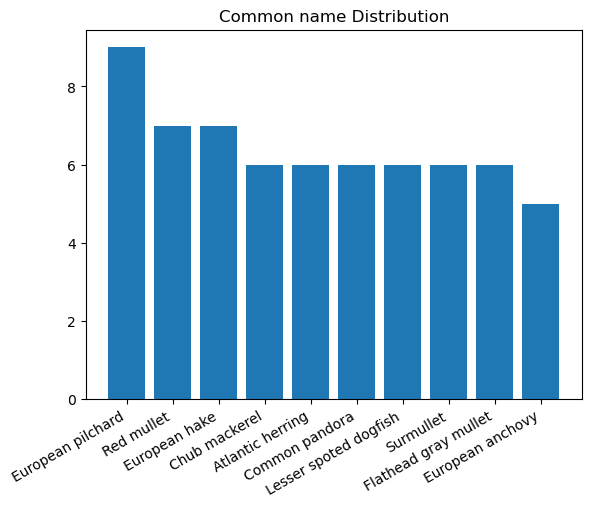

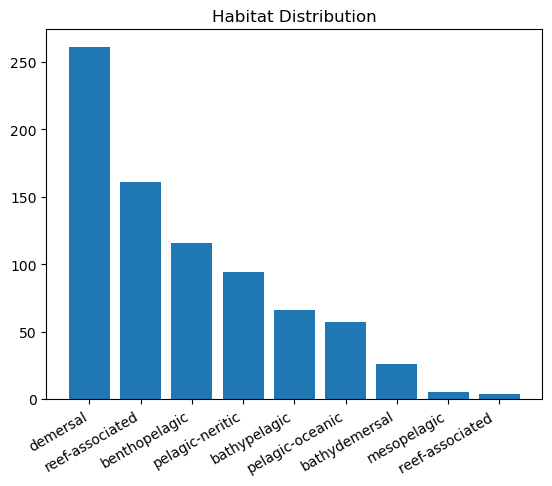

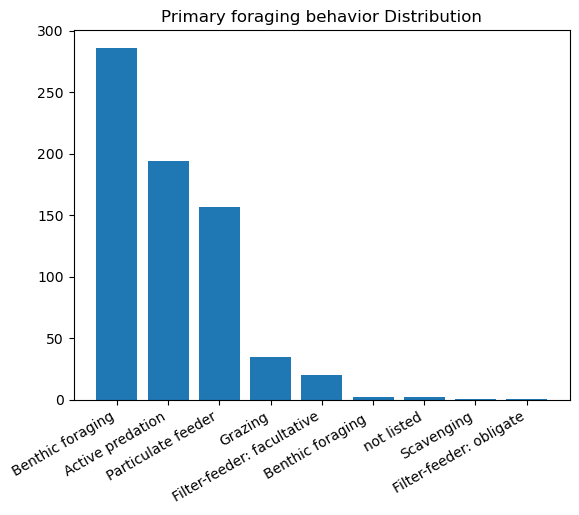

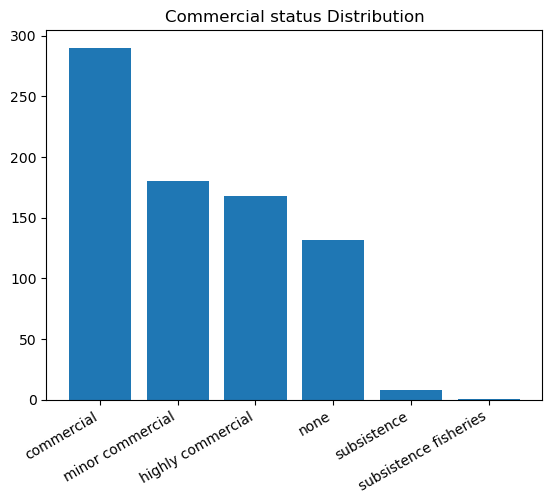

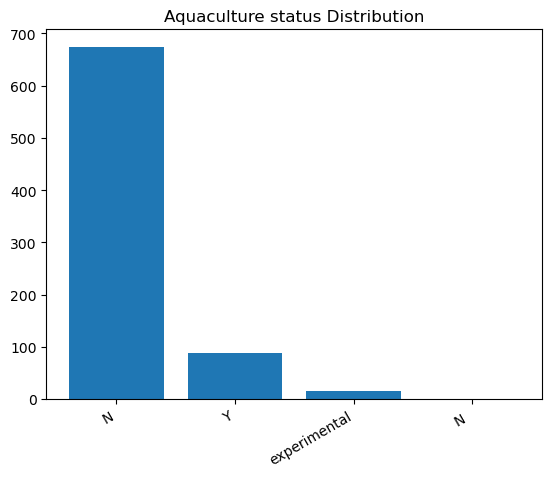

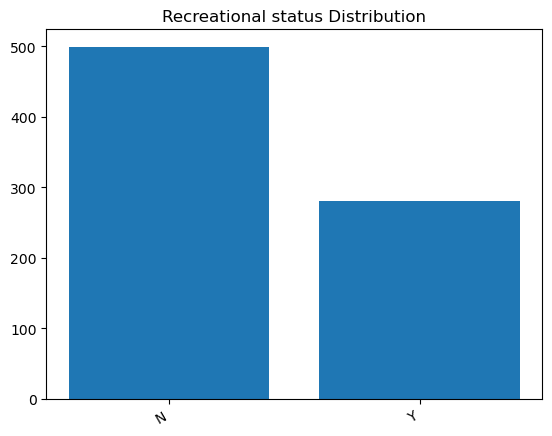

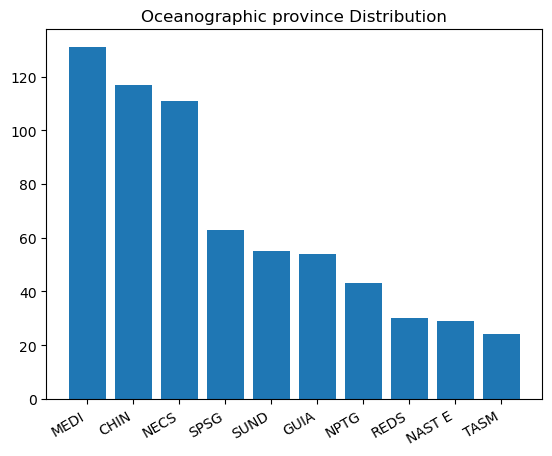

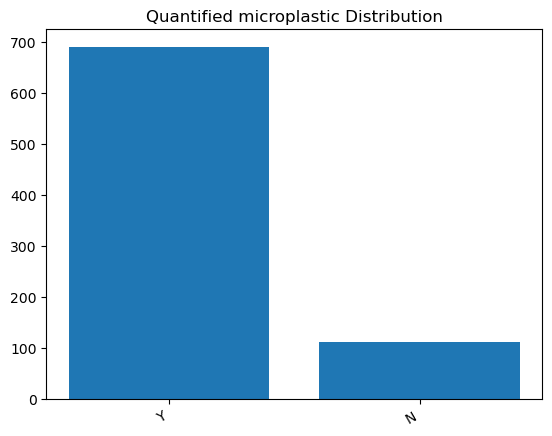

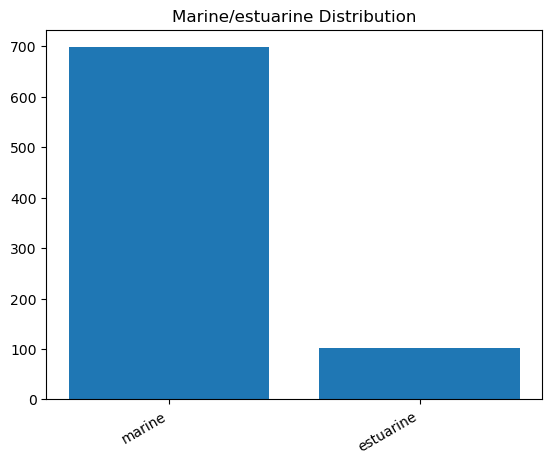

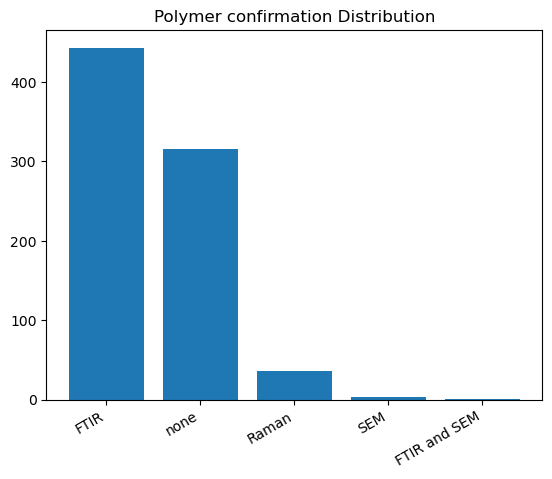

In [6]:
# generate bar chart for each of the object type columns
for col in df_coi_obj.columns:
    
    # get the value counts for the species name column
    counts = df[col].value_counts()
    
    # limit the display to top ten most frequent
    if len(counts.keys()) > 10:
        counts = counts[:10]
    
    # generate, format, and display bar chart
    plt.bar(counts.index, counts.values)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=30, ha='right')
    plt.show()

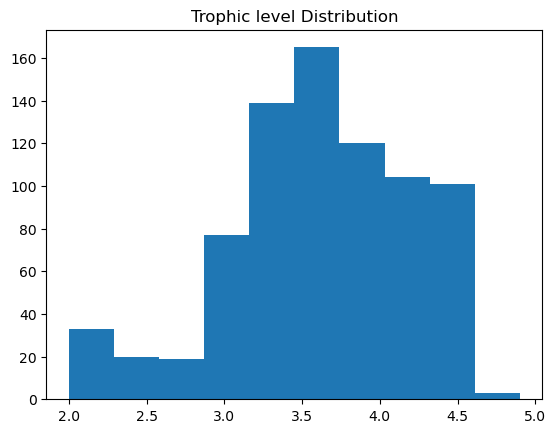

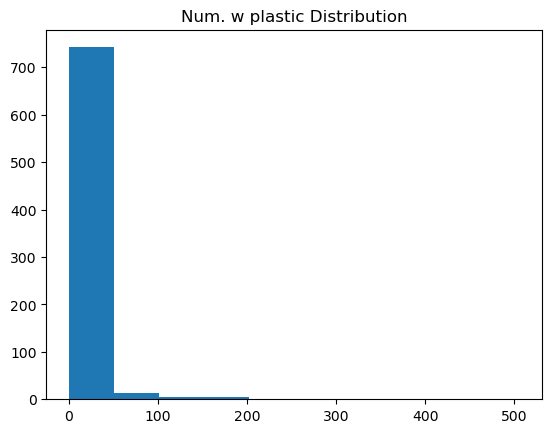

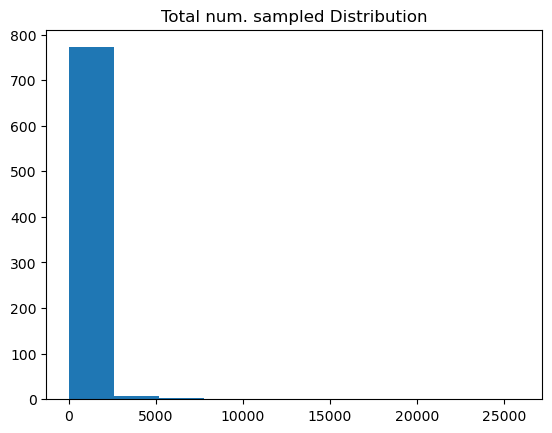

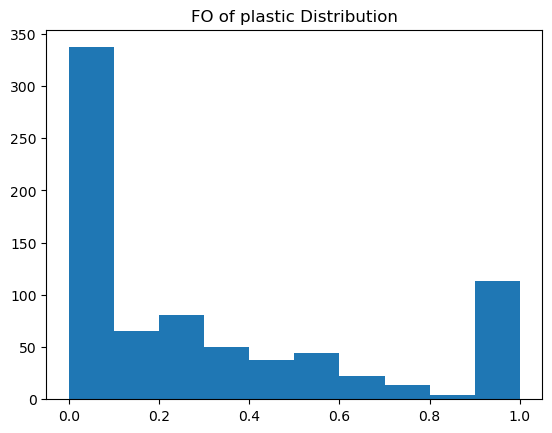

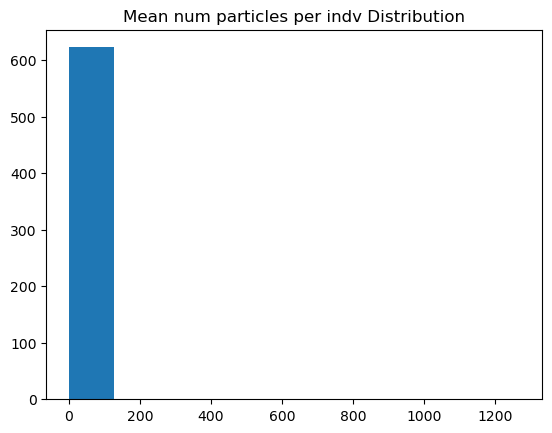

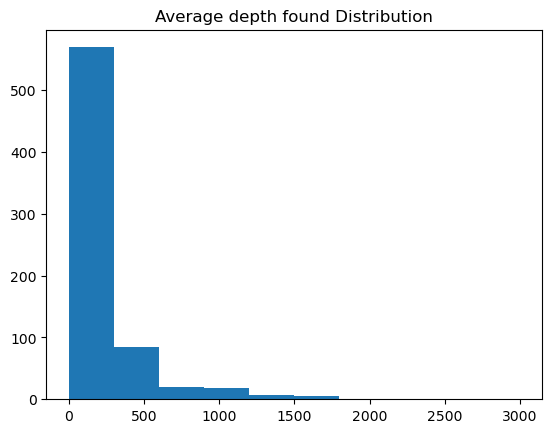

In [7]:
# generate bar chart for each of the object type columns
for col in df_coi_num.columns:
    
    # generate, format, and display bar chart
    plt.hist(df_coi_num[col], )
    plt.title(f'{col} Distribution')
#     plt.xticks(rotation=30, ha='right')
    plt.show()